<a href="https://www.kaggle.com/code/typicalmango/simple-pytorch-ensemble-cnn?scriptVersionId=198693557" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import torch
torch.manual_seed(42)

In [2]:
device = (
    'cuda'
    if torch.cuda.is_available()
    else 'mps'
    if torch.backends.mps.is_available()
    else 'cpu'
)
print(f"Using {device}")

Using cpu


In [3]:
# This code isnt cuda compatible yet
from torch.multiprocessing import Pool, Process, set_start_method

if device=='cuda':
    try:
        set_start_method('spawn')
        print("Start method set")
    except RuntimeError:
        print("Unable to set start method")
        pass
    
device = torch.device(device)

# Loading and Preprocessing Data

In [4]:
from torchvision.transforms import transforms

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
from torchvision.datasets import FashionMNIST

train_set = FashionMNIST(root='./data', train=True, transform=train_transform, download=True)

test_set = FashionMNIST(root='./data', train=False, transform=test_transform, download=True)

100%|██████████| 26421880/26421880 [00:00<00:00, 59334551.73it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 2442532.66it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 34987361.65it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


100%|██████████| 5148/5148 [00:00<00:00, 5487236.85it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [6]:
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2, persistent_workers=True, collate_fn=lambda x: [y.to(device) for y in default_collate(x)])
# train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2, collate_fn=lambda x: [y.to(device) for y in default_collate(x)])

test_loader = DataLoader(test_set, batch_size=64, num_workers=2, persistent_workers=True, collate_fn=lambda x: [y.to(device) for y in default_collate(x)])
# test_loader = DataLoader(test_set, batch_size=64, num_workers=2, collate_fn=lambda x: [y.to(device) for y in default_collate(x)])

In [7]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

# Creating the Ensemble

In [8]:
import torch.nn as nn

class net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [9]:
net()

net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [10]:
learning_rate = 6e-2
batch_size = 64
epochs = 12
num_models = 10

In [11]:
model_ensemble = [net().to(device) for _ in range(num_models)]

# Training the Model

In [12]:
def train_loop(data_loader, model_ensemble, loss_fn):
    size = len(data_loader.dataset)
    for i, model in enumerate(model_ensemble):
        print(f'model {i+1}:')
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
        model.train()
        for batch, (X, y) in enumerate(data_loader):
            pred = model(X)
            loss = loss_fn(pred, y)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            if (batch * batch_size + len(X)) % 3000  == 0:
                loss, current = loss.item(), batch * batch_size + len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        print("-- -- -- -- -- -- -- -- -- -- -")

                
def test_loop(data_loader, model_ensemble, loss_fn):
    for model in model_ensemble:
        model.eval()
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for X, y in data_loader:
            ensemble_preds = [model(X) for model in model_ensemble]
            pred = torch.mean(torch.stack(ensemble_preds), dim=0)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return [100*correct, test_loss]

In [13]:
loss_fn = nn.CrossEntropyLoss()

In [14]:
accuracy_history = []
loss_history = []
for t in range(epochs):
    print(f"Epoch {t+1}\n===============================")
    train_result = train_loop(train_loader, model_ensemble, loss_fn)
    
    test_result = test_loop(test_loader, model_ensemble, loss_fn)
    accuracy_history.append(test_result[0])
    loss_history.append(test_result[1])
print("Done!")

Epoch 1
model 1:
loss: 0.477842  [24000/60000]
loss: 0.387414  [48000/60000]
loss: 0.401083  [60000/60000]
-- -- -- -- -- -- -- -- -- -- -
model 2:
loss: 0.629132  [24000/60000]
loss: 0.522097  [48000/60000]
loss: 0.384938  [60000/60000]
-- -- -- -- -- -- -- -- -- -- -
model 3:
loss: 0.583990  [24000/60000]
loss: 0.592159  [48000/60000]
loss: 0.329152  [60000/60000]
-- -- -- -- -- -- -- -- -- -- -
model 4:
loss: 0.642411  [24000/60000]
loss: 0.316714  [48000/60000]
loss: 0.574958  [60000/60000]
-- -- -- -- -- -- -- -- -- -- -
model 5:
loss: 0.468145  [24000/60000]
loss: 0.403759  [48000/60000]
loss: 0.393955  [60000/60000]
-- -- -- -- -- -- -- -- -- -- -
model 6:
loss: 0.816838  [24000/60000]
loss: 0.567382  [48000/60000]
loss: 0.390885  [60000/60000]
-- -- -- -- -- -- -- -- -- -- -
model 7:
loss: 0.497791  [24000/60000]
loss: 0.525252  [48000/60000]
loss: 0.218770  [60000/60000]
-- -- -- -- -- -- -- -- -- -- -
model 8:
loss: 0.544826  [24000/60000]
loss: 0.443684  [48000/60000]
loss: 

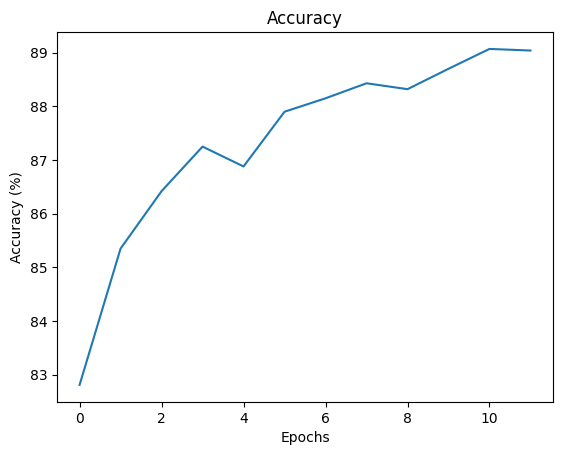

In [15]:
import matplotlib.pyplot as plt

plt.plot(range(len(accuracy_history)), accuracy_history)
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy')
plt.show()

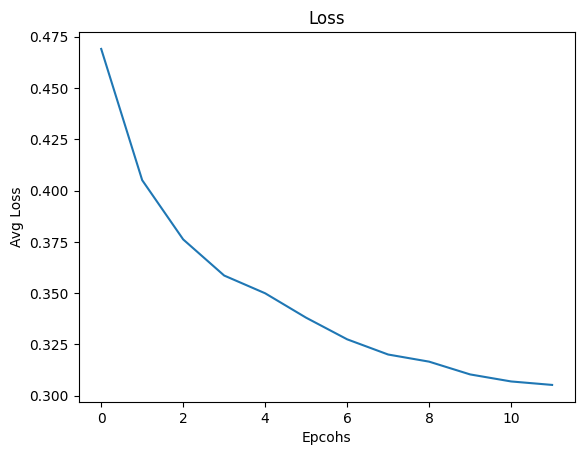

In [16]:
plt.plot(range(len(loss_history)), loss_history)
plt.xlabel('Epcohs')
plt.ylabel('Avg Loss')
plt.title('Loss')
plt.show()

# Evaluation

In [17]:
def test_compare(data_loader, model_ensemble, loss_fn):
    for model in model_ensemble:
        model.eval()
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    
    with torch.no_grad():
        # Comoaring Individual Models
        individual_loss = []
        individual_correct = []
        
        for model in model_ensemble:
            test_loss, correct = 0, 0
            
            for X, y in data_loader:
                pred = model(X)
                test_loss += loss_fn(pred, y)
                correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
            test_loss /= num_batches
            correct /= size
            individual_loss.append(test_loss)
            individual_correct.append(correct)
        print("Individual Performance: ")
        for i in range(num_models):
            print(f"Model {i+1}: \n Accuracy: {(100*individual_correct[i]):>0.1f}%, Avg loss: {individual_loss[i]:>8f}")

        print("\n===============================")
        
        print(f"\nAverage individual performance: \n Accuracy: {(100*sum(individual_correct)/num_models):>0.1f}%, Avg loss: {sum(individual_loss)/num_models:>8f} \n")
        
        print("===============================")
        
        test_loss, correct = 0, 0
        for X, y in data_loader:
            ensemble_preds = [model(X) for model in model_ensemble]
            pred = torch.mean(torch.stack(ensemble_preds), dim=0)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    test_loss /= num_batches
    correct /= size
    print(f"\nEnsemble Performance: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [18]:
test_compare(test_loader, model_ensemble, loss_fn)

Individual Performance: 
Model 1: 
 Accuracy: 86.3%, Avg loss: 0.400015
Model 2: 
 Accuracy: 88.3%, Avg loss: 0.325638
Model 3: 
 Accuracy: 87.9%, Avg loss: 0.341743
Model 4: 
 Accuracy: 87.1%, Avg loss: 0.363249
Model 5: 
 Accuracy: 87.0%, Avg loss: 0.366524
Model 6: 
 Accuracy: 84.1%, Avg loss: 0.443463
Model 7: 
 Accuracy: 88.1%, Avg loss: 0.329904
Model 8: 
 Accuracy: 88.2%, Avg loss: 0.327132
Model 9: 
 Accuracy: 87.5%, Avg loss: 0.342447
Model 10: 
 Accuracy: 87.4%, Avg loss: 0.364583


Average individual performance: 
 Accuracy: 87.2%, Avg loss: 0.360470 


Ensemble Performance: 
 Accuracy: 89.0%, Avg loss: 0.305282 



# Conclusion
Therefore, it can be concluded that the ensemble model outperforms the individual models. <br>
The whole is greater than the sum of its parts!